In [1]:
import sys
sys.path.append('..')

import attack
import data_loader as dl

In [2]:
import geopandas as gp
import pandas as pd
from tqdm import tqdm
import numpy as np
import libpysal
import itertools
from joblib import Parallel, delayed
import random
import matplotlib.pyplot as plt
from shapely import Point
import math
from sklearn import metrics
from tqdm import tqdm
import os
import datetime
tqdm.pandas()

import sys
# sys.stdout = open('logfile', 'w')

In [3]:
# Load data
gdf = gp.read_file('data/freemove/freemove_clustering_HL.geojson').to_crs(4326)

# format clusering_HL columns as object
gdf['clustering_HL'] = gdf['clustering_HL'].astype('object')
gdf['START_POINT'] = gdf.geometry.apply(lambda x: Point(x.coords[0]))
gdf['END_POINT'] = gdf.geometry.apply(lambda x: Point(x.coords[-1]))

gdf = gdf.reset_index(drop=True)

In [4]:
from skmob.tessellation import tilers
import skmob
from shapely.geometry import Polygon


MIN_LNG, MIN_LAT, MAX_LNG, MAX_LAT = 12.562133, 52.099718, 14.129426, 52.803108  # raw_points_gdf.geometry.total_bounds

TILE_DIAMETER_IN_METERS = (
    300  # approximately. For h3 the most appropriate resolution is found
)
TILE_TYPE = "squared"  # other option: "squared", "h3_tessellation"
####################################################################

base_shape = gp.GeoDataFrame(
    index=[0],
    crs=4326,
    geometry=[
        Polygon(
            zip(
                [MIN_LNG, MAX_LNG, MAX_LNG, MIN_LNG],
                [MIN_LAT, MIN_LAT, MAX_LAT, MAX_LAT],
            )
        )
    ],
)

tessellation = tilers.tiler.get(
    TILE_TYPE,
    base_shape=base_shape,
    meters=TILE_DIAMETER_IN_METERS,
)#.drop('H3_INDEX', axis=1)

/usr/local/lib/python3.8/dist-packages/skmob/tessellation/tilers.py:117: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  base_shape = gpd.GeoSeries(cascaded_union(polygons), crs=base_shape.crs)


In [5]:
def get_points(gdf, tessellation):
    sp = gdf[['PERSON_ID', 'TRIP_ID', 'TRIP_START', 'START_POINT', 'clustering_HL']].copy()
    ep = gdf[['PERSON_ID', 'TRIP_ID', 'TRIP_END', 'END_POINT', 'clustering_HL']].copy()


    sp['lat'] = sp.START_POINT.apply(lambda x: x.y)
    sp['lng'] = sp.START_POINT.apply(lambda x: x.x)
    ep['lat'] = ep.END_POINT.apply(lambda x: x.y)
    ep['lng'] = ep.END_POINT.apply(lambda x: x.x)

    sp = sp.rename(columns={'TRIP_START': 'datetime'})
    ep = ep.rename(columns={'TRIP_END': 'datetime'})

    sp.drop('START_POINT', axis=1, inplace=True)
    ep.drop('END_POINT', axis=1, inplace=True)

    points = pd.concat([sp, ep])
    points = gp.GeoDataFrame(points, geometry=gp.points_from_xy(points.lng, points.lat, crs='epsg:4326'))
    
    points = gp.sjoin(points, tessellation, predicate='within', how='left').drop('index_right', axis=1)
    
    return points

print(len(tessellation))
print('nr unique', tessellation.tile_ID.nunique())

tessellation.explore()

In [6]:
def get_location_entropy(tile_id, mapped_points_gdf):
    assert isinstance(tile_id, str)
    t_trips = mapped_points_gdf.query("tile_ID == @tile_id")
    le = 0
    c_l = len(t_trips)
    for p in t_trips.clustering_HL:
        c_l_u = len(t_trips.query('clustering_HL == @p'))
        p_u_l =  c_l_u/ c_l
        le += p_u_l * math.log(p_u_l)
    return -le

In [7]:
def get_inverse_loc_frequency(row, loc_frequencies, points):
    
    tl_ID = str(row.tile_ID)
    cl_ID = row.clustering_HL
    
    cl_loc_freqs = loc_frequencies.query('clustering_HL == @cl_ID')
        
    tf = row.freq/cl_loc_freqs.freq.sum()
    
    idf = math.log(points.clustering_HL.nunique()/(points.query('tile_ID == @tl_ID').clustering_HL.nunique() + 1))
    
    tf_idf = tf * idf
    
    return tf_idf

In [8]:
def get_location_similarity(cl_i, cl_j, loc_frequencies, points):
    overlap_tile_ids = set(loc_frequencies.query("clustering_HL == @cl_i").tile_ID).intersection(set(loc_frequencies.query("clustering_HL == @cl_j").tile_ID))
    nr_overlapping_tiles = len(overlap_tile_ids)
    loc_sim = 0
    
    if nr_overlapping_tiles == 0:
        return loc_sim
    for t in overlap_tile_ids:
        cl_i_freq = loc_frequencies[(loc_frequencies['clustering_HL'] == cl_i) & (loc_frequencies['tile_ID'] == t)].tf_idf.iloc[0]
        cl_j_freq = loc_frequencies[(loc_frequencies['clustering_HL'] == cl_j) & (loc_frequencies['tile_ID'] == t)].tf_idf.iloc[0]
        
        # Alternative 1: Entropy times avg lficf
#         loc_sim += points.query("tile_ID == @t").location_entropy.iloc[0] * (cl_i_freq + cl_j_freq)/2

        # Alternative 2: Interaction between lficfs
        loc_sim += cl_i_freq + cl_j_freq
    return loc_sim/nr_overlapping_tiles

In [9]:
def get_max_n(M, n=10):
    # (score, i, j)
    max_n = [(0,0,0)] * n
    
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if not all(x[0] > M[i,j] for x in max_n):
                index_smallest_val = max_n.index(sorted(max_n, reverse=False)[0])
                max_n[index_smallest_val] = (M[i,j], i, j) # score must be first for sorting later
    
    print('Nr of links that are equal to one of max values: ', sum([sum(M == max_val[0]).sum() for max_val in max_n]))
    return max_n

In [10]:
def find_nr_overlaps(cl_i, cl_j, gdf):
    nr_overlaps = 0
    
    gdf['TRIP_START'] = pd.to_datetime(gdf['TRIP_START'], format='%Y-%m-%d %H:%M:%S')
    gdf['TRIP_END'] = pd.to_datetime(gdf['TRIP_END'], format='%Y-%m-%d %H:%M:%S')
    
    cl_i_trips = gdf.query("clustering_HL == @cl_i").copy()
    cl_j_trips = gdf.query("clustering_HL == @cl_j").copy()
    
    for i, t_i in cl_i_trips.iterrows():
        t_i_s_x = t_i
        t_i_e_x = pd.to_datetime(t_i['TRIP_END'], format='%Y-%m-%d %H:%M:%S')
        
        for i, t_j in cl_j_trips.iterrows():
            if ((t_i.TRIP_START <= t_j.TRIP_START and t_i.TRIP_END >= t_j.TRIP_START) or (t_j.TRIP_START <= t_i.TRIP_START and t_j.TRIP_END >= t_i.TRIP_START) or (t_i.TRIP_START <= t_j.TRIP_START and t_i.TRIP_END >= t_j.TRIP_END) or (t_j.TRIP_START <= t_i.TRIP_START and t_j.TRIP_START >= t_i.TRIP_START)) and (t_i.TRIP_ID != t_j.TRIP_ID):
                print('Overlapping trips in two clusters:', cl_i, cl_j, 'Trips: ', t_i.TRIP_ID, t_j.TRIP_ID)
                nr_overlaps += 1
                
    return nr_overlaps

In [11]:
for cl_id in gdf.clustering_HL.unique():
    if find_nr_overlaps(cl_id,cl_id, gdf) > 0:
        print(cl_id)
        print("error")
    

Overlapping trips in two clusters: 145 145 Trips:  171 187
Overlapping trips in two clusters: 145 145 Trips:  187 171
145
error


In [11]:
def store_results_recursive_search(clustering, gdf):
    ground_truth = attack.getGroundTruth(gdf)
    
    # Write all clustering metrics of evaluate() to csv and add columns for parameters
    result_dicts = []
    result_dict = {}
    result_dict['Homogeneity'] = metrics.homogeneity_score(ground_truth, clustering)
    result_dict['Completeness'] = metrics.completeness_score(ground_truth, clustering)
    result_dict['V-measure'] = metrics.v_measure_score(ground_truth, clustering)
    result_dict['Rand index'] = metrics.rand_score(ground_truth, clustering)
    result_dict['ARI'] = metrics.adjusted_rand_score(ground_truth, clustering)
    result_dict['MI'] = metrics.mutual_info_score(ground_truth, clustering)
    result_dict['NMI'] = metrics.normalized_mutual_info_score(ground_truth, clustering)
    result_dict['AMI'] = metrics.adjusted_mutual_info_score(ground_truth, clustering)
    result_dict['Cluster accuracy'] = attack.cluster_acc(ground_truth, clustering)
    result_dicts.append(result_dict)

    df = pd.DataFrame(result_dicts)

    # Add column with date and time
    df['Date'] = datetime.datetime.now().strftime("%Y-%m-%d")
    df['Time'] = datetime.datetime.now().strftime("%H:%M:%S")

    # Check if file exists
    file_exists = os.path.isfile('results_recursive_search.csv')

    # Write to csv (append)
    if not file_exists:
        df.to_csv('results_recursive_search.csv', mode='a', header=True, index=False)
    else:
        df.to_csv('results_recursive_search.csv', mode='a', header=False, index=False)


Next Iteration:  1


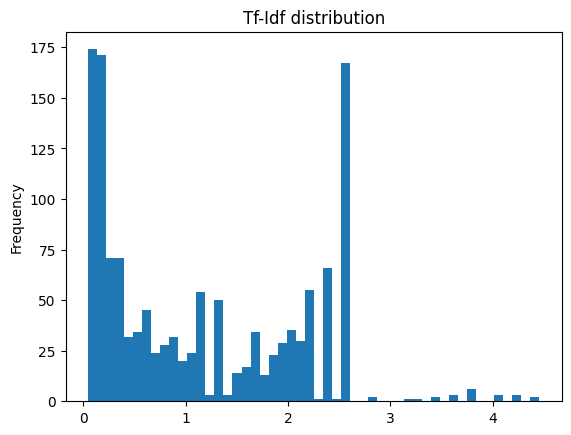

100%|█████████████████████████████████████████████████████████████████████████████████| 344/344 [03:10<00:00,  1.81it/s]


New links of clusters:
Nr of links that are equal to one of max values:  244
[(8.462407489878595, 311, 313), (8.462407489878595, 313, 311), (7.522400231387125, 242, 238), (7.522400231387125, 242, 239), (7.522400231387125, 242, 241), (7.522400231387125, 241, 240), (7.522400231387125, 241, 242), (7.522400231387125, 242, 163), (7.522400231387125, 241, 239), (7.522400231387125, 242, 240)]
[(8.462407489878595, 311, 313), (8.462407489878595, 313, 311), (7.522400231387125, 242, 238), (7.522400231387125, 242, 239), (7.522400231387125, 242, 241), (7.522400231387125, 241, 240), (7.522400231387125, 241, 242), (7.522400231387125, 242, 163), (7.522400231387125, 241, 239), (7.522400231387125, 242, 240)]
314 312
312 314
243 242
243 241
243 240
Homogeneity: 0.931
Completeness: 0.729
V-measure: 0.818
Rand index: 0.983
ARI: 0.496
MI: 3.666
NMI: 0.818
AMI: 0.667
Cluster accuracy: 0.554
Iteration 1 done.  340 clusters left.

Next Iteration:  2


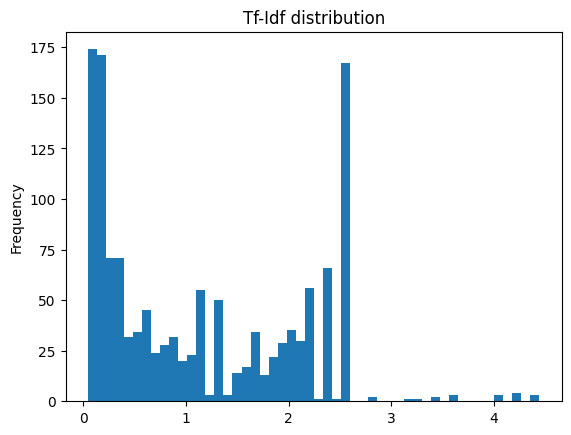

100%|█████████████████████████████████████████████████████████████████████████████████| 340/340 [03:02<00:00,  1.87it/s]


New links of clusters:
Nr of links that are equal to one of max values:  60
[(8.439015410352214, 239, 238), (7.263442080547976, 270, 266), (7.263442080547976, 270, 265), (8.439015410352214, 239, 163), (7.263442080547976, 266, 270), (8.439015410352214, 163, 238), (8.439015410352214, 238, 163), (8.439015410352214, 163, 239), (7.263442080547976, 266, 265), (8.439015410352214, 238, 239)]
[(8.439015410352214, 239, 238), (7.263442080547976, 270, 266), (7.263442080547976, 270, 265), (8.439015410352214, 239, 163), (7.263442080547976, 266, 270), (8.439015410352214, 163, 238), (8.439015410352214, 238, 163), (8.439015410352214, 163, 239), (7.263442080547976, 266, 265), (8.439015410352214, 238, 239)]
243 239
243 164
239 243
239 164
164 243
Homogeneity: 0.931
Completeness: 0.730
V-measure: 0.818
Rand index: 0.983
ARI: 0.496
MI: 3.666
NMI: 0.818
AMI: 0.669
Cluster accuracy: 0.556
Iteration 2 done.  338 clusters left.

Next Iteration:  3


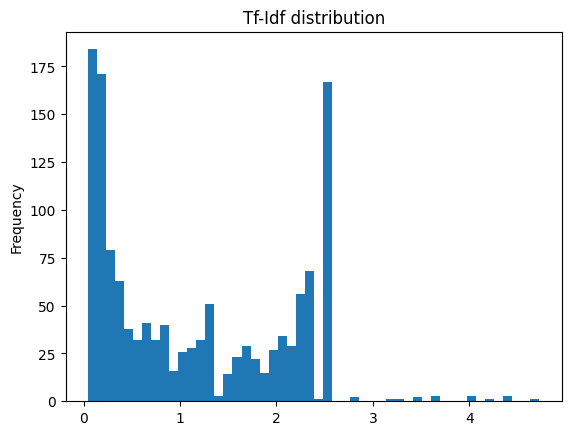

100%|█████████████████████████████████████████████████████████████████████████████████| 338/338 [02:58<00:00,  1.90it/s]


New links of clusters:
Nr of links that are equal to one of max values:  52
[(7.251642636293599, 264, 268), (6.655127301544692, 306, 307), (7.251642636293599, 263, 264), (7.251642636293599, 268, 263), (6.655127301544692, 307, 306), (7.251642636293599, 263, 268), (7.251642636293599, 264, 263), (7.086650410222363, 256, 237), (7.251642636293599, 268, 264), (7.086650410222363, 237, 256)]
[(7.251642636293599, 264, 268), (6.655127301544692, 306, 307), (7.251642636293599, 263, 264), (7.251642636293599, 268, 263), (6.655127301544692, 307, 306), (7.251642636293599, 263, 268), (7.251642636293599, 264, 263), (7.086650410222363, 256, 237), (7.251642636293599, 268, 264), (7.086650410222363, 237, 256)]
274 270
274 269
270 274
270 269
269 274
Homogeneity: 0.931
Completeness: 0.730
V-measure: 0.818
Rand index: 0.983
ARI: 0.497
MI: 3.666
NMI: 0.818
AMI: 0.669
Cluster accuracy: 0.556
Iteration 3 done.  336 clusters left.

Next Iteration:  4


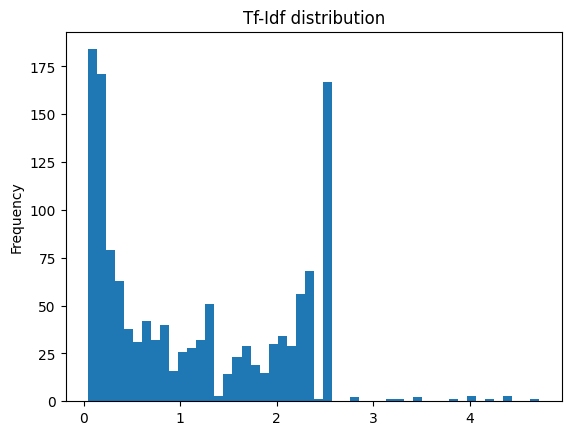

100%|█████████████████████████████████████████████████████████████████████████████████| 336/336 [02:57<00:00,  1.89it/s]


New links of clusters:
Nr of links that are equal to one of max values:  44
[(6.64622519826497, 305, 304), (6.64622519826497, 229, 279), (6.311509871293655, 188, 24), (6.64622519826497, 304, 305), (7.077748306942642, 256, 237), (6.64622519826497, 279, 229), (6.64622519826497, 229, 230), (7.077748306942642, 237, 256), (6.311509871293655, 24, 188), (6.64622519826497, 230, 229)]
[(6.64622519826497, 305, 304), (6.64622519826497, 229, 279), (6.311509871293655, 188, 24), (6.64622519826497, 304, 305), (7.077748306942642, 256, 237), (6.64622519826497, 279, 229), (6.64622519826497, 229, 230), (7.077748306942642, 237, 256), (6.311509871293655, 24, 188), (6.64622519826497, 230, 229)]
262 239
239 262
313 312
312 313
287 231
Homogeneity: 0.931
Completeness: 0.731
V-measure: 0.819
Rand index: 0.983
ARI: 0.497
MI: 3.666
NMI: 0.819
AMI: 0.671
Cluster accuracy: 0.558
Iteration 4 done.  333 clusters left.

Next Iteration:  5


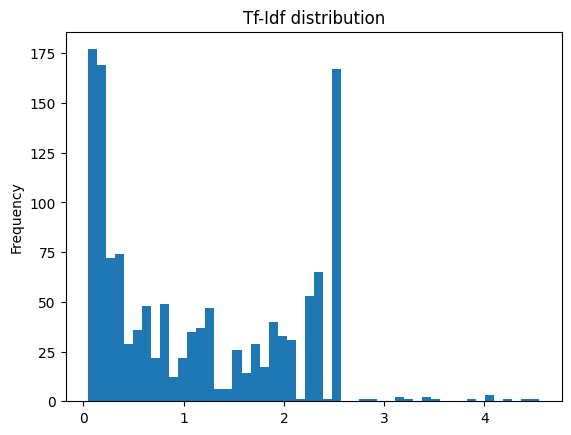

100%|█████████████████████████████████████████████████████████████████████████████████| 333/333 [02:55<00:00,  1.90it/s]


New links of clusters:
Nr of links that are equal to one of max values:  116
[(6.024574531128582, 211, 182), (6.024574531128582, 183, 182), (6.024574531128582, 253, 67), (6.024574531128582, 185, 182), (6.298056866319515, 24, 188), (6.298056866319515, 188, 24), (6.024574531128582, 310, 67), (6.024574531128582, 220, 67), (6.024574531128582, 257, 272), (6.024574531128582, 272, 257)]
[(6.024574531128582, 211, 182), (6.024574531128582, 183, 182), (6.024574531128582, 253, 67), (6.024574531128582, 185, 182), (6.298056866319515, 24, 188), (6.298056866319515, 188, 24), (6.024574531128582, 310, 67), (6.024574531128582, 220, 67), (6.024574531128582, 257, 272), (6.024574531128582, 272, 257)]
190 25
25 190
322 68
282 265
265 282
Homogeneity: 0.930
Completeness: 0.731
V-measure: 0.819
Rand index: 0.983
ARI: 0.497
MI: 3.665
NMI: 0.819
AMI: 0.671
Cluster accuracy: 0.558
Iteration 5 done.  330 clusters left.

Next Iteration:  6


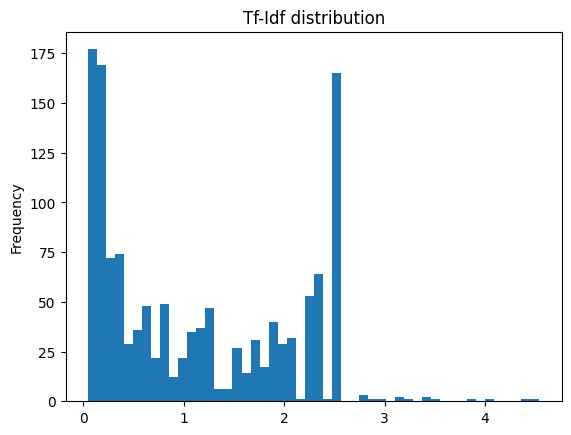

100%|█████████████████████████████████████████████████████████████████████████████████| 330/330 [02:56<00:00,  1.87it/s]


New links of clusters:
Nr of links that are equal to one of max values:  60
[(6.010999777848706, 181, 184), (6.010999777848706, 181, 209), (5.779773758107819, 259, 263), (6.010999777848706, 184, 181), (6.010999777848706, 181, 182), (5.779773758107819, 261, 259), (5.779773758107819, 263, 259), (6.010999777848706, 209, 181), (5.779773758107819, 262, 259), (6.010999777848706, 182, 181)]
[(6.010999777848706, 181, 184), (6.010999777848706, 181, 209), (5.779773758107819, 259, 263), (6.010999777848706, 184, 181), (6.010999777848706, 181, 182), (5.779773758107819, 261, 259), (5.779773758107819, 263, 259), (6.010999777848706, 209, 181), (5.779773758107819, 262, 259), (6.010999777848706, 182, 181)]
213 184
187 184
185 184
184 213
184 187
Homogeneity: 0.930
Completeness: 0.732
V-measure: 0.819
Rand index: 0.983
ARI: 0.497
MI: 3.665
NMI: 0.819
AMI: 0.672
Cluster accuracy: 0.558
Iteration 6 done.  328 clusters left.

Next Iteration:  7


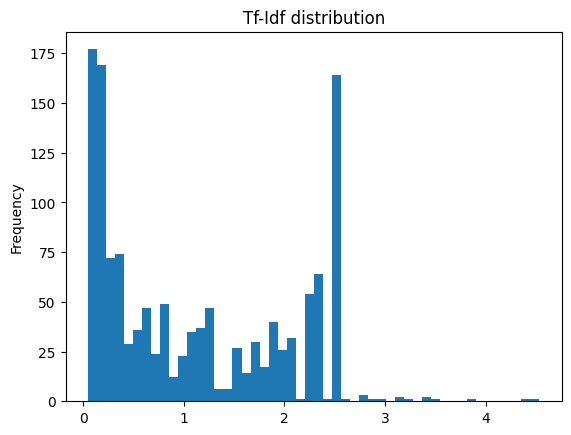

100%|█████████████████████████████████████████████████████████████████████████████████| 328/328 [02:51<00:00,  1.92it/s]


New links of clusters:
Nr of links that are equal to one of max values:  44
[(5.476801539668706, 272, 225), (5.770655188993246, 257, 261), (5.770655188993246, 257, 259), (5.288063096717104, 11, 233), (5.288063096717104, 233, 11), (5.770655188993246, 261, 257), (5.770655188993246, 259, 257), (5.476801539668706, 225, 272), (5.770655188993246, 260, 257), (5.770655188993246, 257, 260)]
[(5.476801539668706, 272, 225), (5.770655188993246, 257, 261), (5.770655188993246, 257, 259), (5.288063096717104, 11, 233), (5.288063096717104, 233, 11), (5.770655188993246, 261, 257), (5.770655188993246, 259, 257), (5.476801539668706, 225, 272), (5.770655188993246, 260, 257), (5.770655188993246, 257, 260)]
275 270
273 270
272 270
270 275
270 273
Homogeneity: 0.930
Completeness: 0.732
V-measure: 0.820
Rand index: 0.983
ARI: 0.498
MI: 3.665
NMI: 0.820
AMI: 0.673
Cluster accuracy: 0.558
Iteration 7 done.  326 clusters left.

Next Iteration:  8


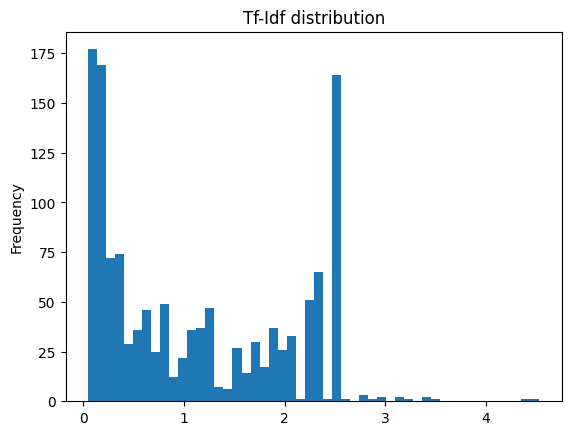

100%|█████████████████████████████████████████████████████████████████████████████████| 326/326 [02:48<00:00,  1.93it/s]


New links of clusters:
Nr of links that are equal to one of max values:  28
[(5.28072362429618, 233, 11), (5.28072362429618, 11, 233), (5.469665941481697, 225, 270), (4.8406633222714985, 182, 181), (4.8406633222714985, 181, 182), (5.469665941481697, 270, 225), (4.873702713754708, 303, 249), (4.873702713754708, 216, 303), (4.873702713754708, 303, 216), (4.873702713754708, 249, 303)]
[(5.28072362429618, 233, 11), (5.28072362429618, 11, 233), (5.469665941481697, 225, 270), (4.8406633222714985, 182, 181), (4.8406633222714985, 181, 182), (5.469665941481697, 270, 225), (4.873702713754708, 303, 249), (4.873702713754708, 216, 303), (4.873702713754708, 303, 216), (4.873702713754708, 249, 303)]
287 232
232 287
244 12
12 244
322 260
Homogeneity: 0.930
Completeness: 0.733
V-measure: 0.820
Rand index: 0.983
ARI: 0.498
MI: 3.663
NMI: 0.820
AMI: 0.674
Cluster accuracy: 0.559
Iteration 8 done.  323 clusters left.

Next Iteration:  9


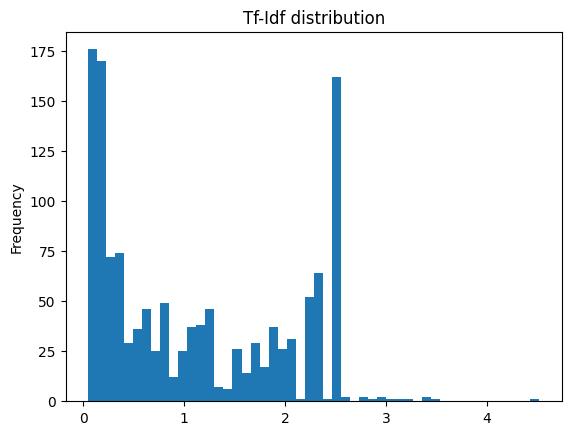

100%|█████████████████████████████████████████████████████████████████████████████████| 323/323 [02:44<00:00,  1.97it/s]


New links of clusters:
Nr of links that are equal to one of max values:  52
[(4.81905444864168, 128, 208), (4.81905444864168, 306, 208), (4.81905444864168, 208, 306), (4.830493758313042, 300, 216), (4.81905444864168, 208, 307), (4.81905444864168, 307, 208), (4.830493758313042, 181, 182), (4.81905444864168, 208, 128), (4.830493758313042, 182, 181), (4.830493758313042, 216, 300)]
[(4.81905444864168, 128, 208), (4.81905444864168, 306, 208), (4.81905444864168, 208, 306), (4.830493758313042, 300, 216), (4.81905444864168, 208, 307), (4.81905444864168, 307, 208), (4.830493758313042, 181, 182), (4.81905444864168, 208, 128), (4.830493758313042, 182, 181), (4.830493758313042, 216, 300)]
322 222
222 322
185 184
184 185
329 214
Homogeneity: 0.929
Completeness: 0.733
V-measure: 0.820
Rand index: 0.983
ARI: 0.499
MI: 3.660
NMI: 0.820
AMI: 0.674
Cluster accuracy: 0.559
Iteration 9 done.  320 clusters left.

Next Iteration:  10


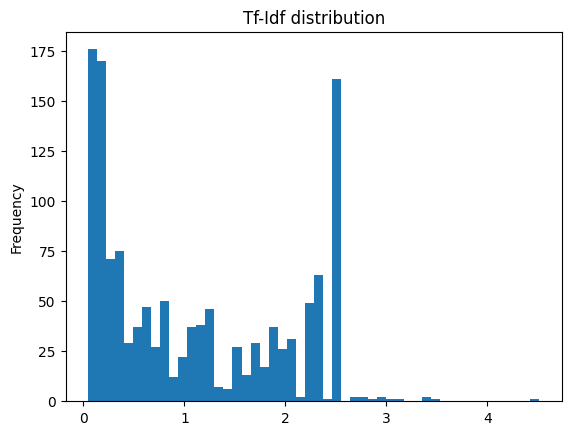

100%|█████████████████████████████████████████████████████████████████████████████████| 320/320 [02:41<00:00,  1.98it/s]


New links of clusters:
Nr of links that are equal to one of max values:  148
[(4.669708707125663, 267, 118), (4.669708707125663, 284, 246), (4.695028537150587, 71, 197), (4.669708707125663, 290, 170), (4.669708707125663, 237, 236), (4.695028537150587, 197, 71), (4.669708707125663, 246, 284), (4.669708707125663, 279, 107), (4.669708707125663, 288, 127), (4.669708707125663, 275, 221)]
[(4.669708707125663, 267, 118), (4.669708707125663, 284, 246), (4.695028537150587, 71, 197), (4.669708707125663, 290, 170), (4.669708707125663, 237, 236), (4.695028537150587, 197, 71), (4.669708707125663, 246, 284), (4.669708707125663, 279, 107), (4.669708707125663, 288, 127), (4.669708707125663, 275, 221)]
203 73
73 203
312 173
310 129
306 261
Homogeneity: 0.929
Completeness: 0.734
V-measure: 0.820
Rand index: 0.983
ARI: 0.499
MI: 3.659
NMI: 0.820
AMI: 0.675
Cluster accuracy: 0.561
Iteration 10 done.  316 clusters left.

Next Iteration:  11


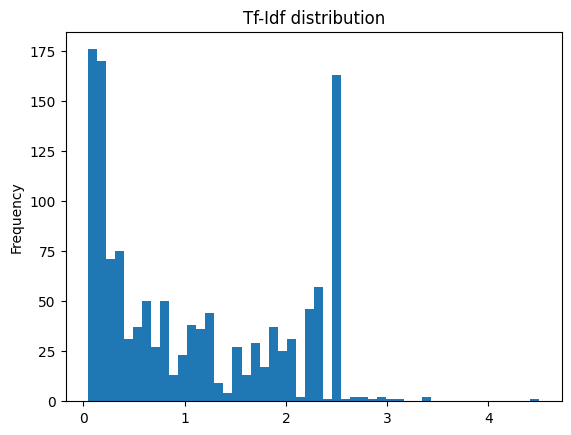

100%|█████████████████████████████████████████████████████████████████████████████████| 316/316 [02:35<00:00,  2.03it/s]


New links of clusters:
Nr of links that are equal to one of max values:  120
[(4.657129924918802, 271, 218), (4.657129924918802, 210, 192), (4.657129924918802, 198, 228), (4.657129924918802, 192, 210), (4.657129924918802, 275, 107), (4.657129924918802, 218, 271), (4.657129924918802, 228, 198), (4.657129924918802, 263, 118), (4.657129924918802, 233, 234), (4.657129924918802, 234, 233)]
[(4.657129924918802, 271, 218), (4.657129924918802, 210, 192), (4.657129924918802, 198, 228), (4.657129924918802, 192, 210), (4.657129924918802, 275, 107), (4.657129924918802, 218, 271), (4.657129924918802, 228, 198), (4.657129924918802, 263, 118), (4.657129924918802, 233, 234), (4.657129924918802, 234, 233)]
301 109
297 229
289 120
251 250
250 251
Homogeneity: 0.928
Completeness: 0.734
V-measure: 0.820
Rand index: 0.983
ARI: 0.499
MI: 3.656
NMI: 0.820
AMI: 0.675
Cluster accuracy: 0.561
Iteration 11 done.  312 clusters left.

Next Iteration:  12


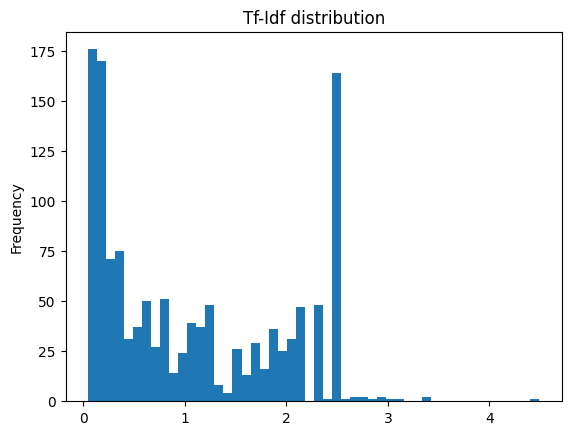

100%|█████████████████████████████████████████████████████████████████████████████████| 312/312 [02:36<00:00,  1.99it/s]


New links of clusters:
Nr of links that are equal to one of max values:  148
[(4.6443908991413725, 208, 190), (4.356708826689592, 301, 219), (4.356708826689592, 278, 279), (4.356708826689592, 298, 193), (4.6443908991413725, 190, 208), (4.356708826689592, 284, 283), (4.356708826689592, 283, 284), (4.356708826689592, 279, 278), (4.6443908991413725, 196, 225), (4.6443908991413725, 225, 196)]
[(4.6443908991413725, 208, 190), (4.356708826689592, 301, 219), (4.356708826689592, 278, 279), (4.356708826689592, 298, 193), (4.6443908991413725, 190, 208), (4.356708826689592, 284, 283), (4.356708826689592, 283, 284), (4.356708826689592, 279, 278), (4.6443908991413725, 196, 225), (4.6443908991413725, 225, 196)]
245 207
221 200
207 245
200 221
334 234
Homogeneity: 0.928
Completeness: 0.734
V-measure: 0.820
Rand index: 0.983
ARI: 0.499
MI: 3.656
NMI: 0.820
AMI: 0.676
Cluster accuracy: 0.563
Iteration 12 done.  309 clusters left.

Next Iteration:  13


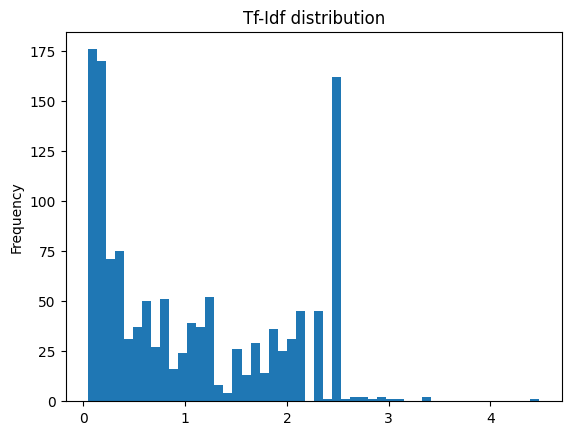

100%|█████████████████████████████████████████████████████████████████████████████████| 309/309 [02:30<00:00,  2.05it/s]


New links of clusters:
Nr of links that are equal to one of max values:  200
[(4.347046915777855, 245, 232), (4.347046915777855, 232, 245), (4.347046915777855, 280, 281), (4.347046915777855, 275, 276), (4.347046915777855, 180, 179), (4.347046915777855, 281, 280), (4.347046915777855, 276, 275), (4.347046915777855, 295, 193), (4.347046915777855, 193, 295), (4.347046915777855, 239, 77)]
[(4.347046915777855, 245, 232), (4.347046915777855, 232, 245), (4.347046915777855, 280, 281), (4.347046915777855, 275, 276), (4.347046915777855, 180, 179), (4.347046915777855, 281, 280), (4.347046915777855, 276, 275), (4.347046915777855, 295, 193), (4.347046915777855, 193, 295), (4.347046915777855, 239, 77)]
331 204
316 315
315 316
309 308
308 309
Homogeneity: 0.928
Completeness: 0.735
V-measure: 0.820
Rand index: 0.983
ARI: 0.500
MI: 3.656
NMI: 0.820
AMI: 0.677
Cluster accuracy: 0.563
Iteration 13 done.  306 clusters left.

Next Iteration:  14


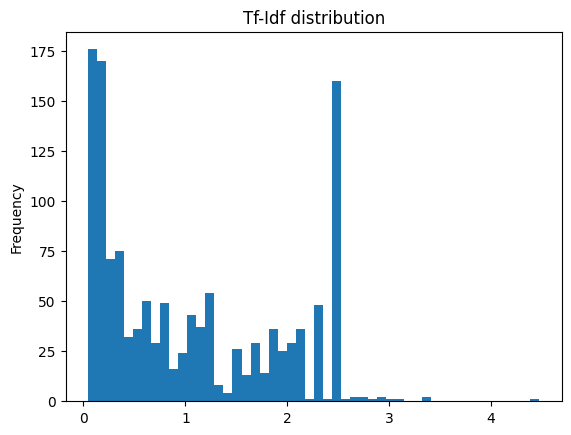

100%|█████████████████████████████████████████████████████████████████████████████████| 306/306 [02:27<00:00,  2.07it/s]


New links of clusters:
Nr of links that are equal to one of max values:  116
[(4.33729074083249, 174, 175), (4.33729074083249, 231, 244), (4.514854412967978, 274, 21), (4.33729074083249, 238, 77), (4.33729074083249, 180, 179), (4.33729074083249, 175, 172), (4.514854412967978, 21, 274), (4.33729074083249, 179, 180), (4.33729074083249, 244, 231), (4.33729074083249, 175, 174)]
[(4.33729074083249, 174, 175), (4.33729074083249, 231, 244), (4.514854412967978, 274, 21), (4.33729074083249, 238, 77), (4.33729074083249, 180, 179), (4.33729074083249, 175, 172), (4.514854412967978, 21, 274), (4.33729074083249, 179, 180), (4.33729074083249, 244, 231), (4.33729074083249, 175, 174)]
308 22
22 308
276 256
266 79
256 276
Homogeneity: 0.928
Completeness: 0.736
V-measure: 0.821
Rand index: 0.984
ARI: 0.502
MI: 3.655
NMI: 0.821
AMI: 0.679
Cluster accuracy: 0.564
Iteration 14 done.  303 clusters left.

Next Iteration:  15


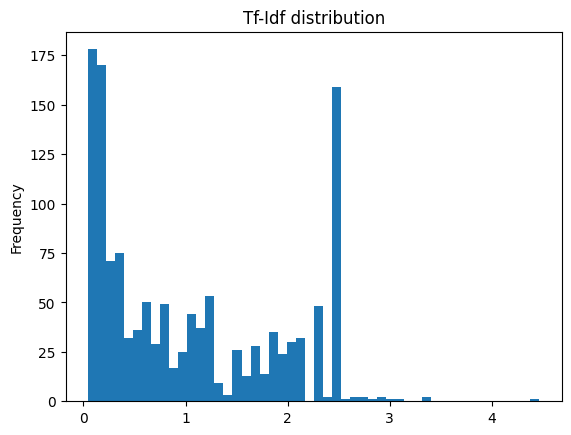

100%|█████████████████████████████████████████████████████████████████████████████████| 303/303 [02:24<00:00,  2.10it/s]


New links of clusters:
Nr of links that are equal to one of max values:  100
[(4.327438444389479, 174, 173), (4.327438444389479, 56, 63), (4.327438444389479, 171, 173), (4.327438444389479, 63, 56), (4.327438444389479, 174, 171), (4.327438444389479, 179, 178), (4.327438444389479, 173, 171), (4.327438444389479, 171, 174), (4.327438444389479, 178, 179), (4.327438444389479, 173, 174)]
[(4.327438444389479, 174, 173), (4.327438444389479, 56, 63), (4.327438444389479, 171, 173), (4.327438444389479, 63, 56), (4.327438444389479, 174, 171), (4.327438444389479, 179, 178), (4.327438444389479, 173, 171), (4.327438444389479, 171, 174), (4.327438444389479, 178, 179), (4.327438444389479, 173, 174)]
189 188
188 189
182 181
182 179
181 182
Homogeneity: 0.928
Completeness: 0.736
V-measure: 0.821
Rand index: 0.984
ARI: 0.502
MI: 3.655
NMI: 0.821
AMI: 0.680
Cluster accuracy: 0.564
Iteration 15 done.  300 clusters left.

Next Iteration:  16


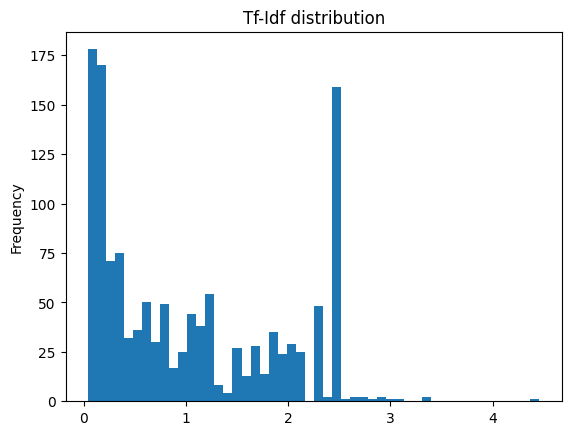

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [02:21<00:00,  2.12it/s]


New links of clusters:
Nr of links that are equal to one of max values:  128
[(4.295026057273025, 239, 237), (4.31748811353631, 56, 63), (4.0943445622221, 283, 224), (4.31748811353631, 63, 56), (4.0943445622221, 257, 185), (4.0943445622221, 251, 257), (4.0943445622221, 257, 251), (4.0943445622221, 257, 249), (4.0943445622221, 251, 249), (4.295026057273025, 237, 239)]
[(4.295026057273025, 239, 237), (4.31748811353631, 56, 63), (4.0943445622221, 283, 224), (4.31748811353631, 63, 56), (4.0943445622221, 257, 185), (4.0943445622221, 251, 257), (4.0943445622221, 257, 251), (4.0943445622221, 257, 249), (4.0943445622221, 251, 249), (4.295026057273025, 237, 239)]
64 57
57 64
272 270
270 272
328 253
Homogeneity: 0.928
Completeness: 0.737
V-measure: 0.822
Rand index: 0.984
ARI: 0.503
MI: 3.655
NMI: 0.822
AMI: 0.681
Cluster accuracy: 0.564
Iteration 16 done.  297 clusters left.

Next Iteration:  17


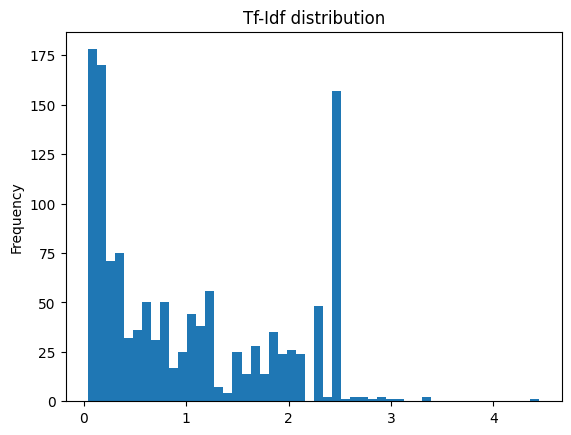

100%|█████████████████████████████████████████████████████████████████████████████████| 297/297 [02:20<00:00,  2.11it/s]


New links of clusters:
Nr of links that are equal to one of max values:  180
[(4.084294226368599, 254, 246), (4.084294226368599, 254, 248), (4.084294226368599, 246, 184), (4.084294226368599, 248, 246), (4.084294226368599, 206, 172), (4.084294226368599, 246, 248), (4.084294226368599, 248, 254), (4.084294226368599, 254, 184), (4.084294226368599, 248, 184), (4.084294226368599, 246, 254)]
[(4.084294226368599, 254, 246), (4.084294226368599, 254, 248), (4.084294226368599, 246, 184), (4.084294226368599, 248, 246), (4.084294226368599, 206, 172), (4.084294226368599, 246, 248), (4.084294226368599, 248, 254), (4.084294226368599, 254, 184), (4.084294226368599, 248, 184), (4.084294226368599, 246, 254)]
296 290
296 288
296 199
290 296
290 288
Homogeneity: 0.928
Completeness: 0.738
V-measure: 0.822
Rand index: 0.984
ARI: 0.503
MI: 3.655
NMI: 0.822
AMI: 0.682
Cluster accuracy: 0.566
Iteration 17 done.  294 clusters left.

Next Iteration:  18


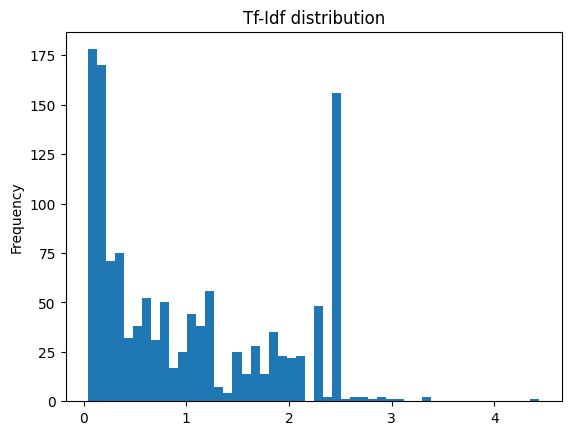

100%|█████████████████████████████████████████████████████████████████████████████████| 294/294 [02:18<00:00,  2.13it/s]


New links of clusters:
Nr of links that are equal to one of max values:  52
[(4.074141854904581, 172, 205), (3.905905736593975, 243, 242), (4.074141854904581, 43, 167), (4.074141854904581, 86, 202), (4.074141854904581, 205, 172), (3.939178289033891, 234, 164), (3.905905736593975, 243, 241), (4.074141854904581, 202, 86), (4.074141854904581, 167, 43), (3.939178289033891, 164, 234)]
[(4.074141854904581, 172, 205), (3.905905736593975, 243, 242), (4.074141854904581, 43, 167), (4.074141854904581, 86, 202), (4.074141854904581, 205, 172), (3.939178289033891, 234, 164), (3.905905736593975, 243, 241), (4.074141854904581, 202, 86), (4.074141854904581, 167, 43), (3.939178289033891, 164, 234)]
226 183
223 90
183 226
176 44
90 223
Homogeneity: 0.928
Completeness: 0.738
V-measure: 0.822
Rand index: 0.984
ARI: 0.503
MI: 3.655
NMI: 0.822
AMI: 0.683
Cluster accuracy: 0.566
Iteration 18 done.  291 clusters left.

Next Iteration:  19


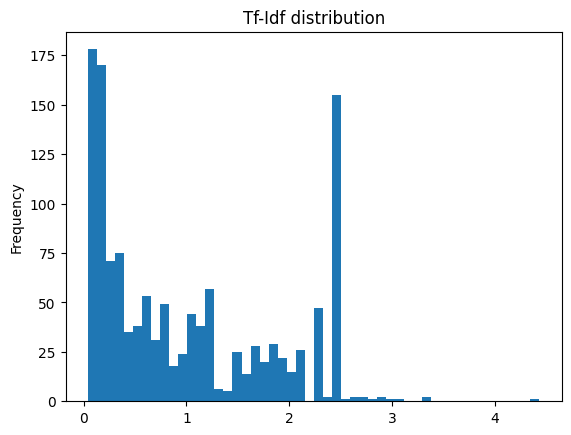

100%|█████████████████████████████████████████████████████████████████████████████████| 291/291 [02:29<00:00,  1.95it/s]


New links of clusters:
Nr of links that are equal to one of max values:  44
[(3.895649236426786, 240, 239), (3.895649236426786, 240, 238), (3.929776497213968, 163, 231), (3.8851199461092643, 163, 118), (3.8851199461092643, 118, 163), (3.895649236426786, 238, 240), (3.929776497213968, 231, 163), (3.895649236426786, 238, 239), (3.895649236426786, 239, 238), (3.895649236426786, 239, 240)]
[(3.895649236426786, 240, 239), (3.895649236426786, 240, 238), (3.929776497213968, 163, 231), (3.8851199461092643, 163, 118), (3.8851199461092643, 118, 163), (3.895649236426786, 238, 240), (3.929776497213968, 231, 163), (3.895649236426786, 238, 239), (3.895649236426786, 239, 238), (3.895649236426786, 239, 240)]
270 172
172 270
285 284
285 283
284 285
Homogeneity: 0.928
Completeness: 0.739
V-measure: 0.823
Rand index: 0.984
ARI: 0.504
MI: 3.655
NMI: 0.823
AMI: 0.685
Cluster accuracy: 0.566
Iteration 19 done.  288 clusters left.

Next Iteration:  20


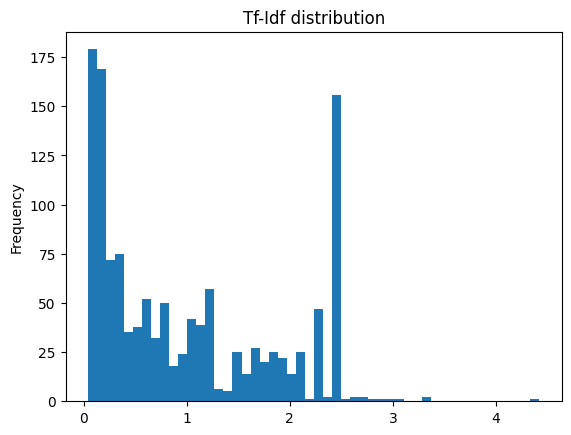

100%|█████████████████████████████████████████████████████████████████████████████████| 288/288 [02:22<00:00,  2.02it/s]


New links of clusters:
Nr of links that are equal to one of max values:  180
[(3.871201010907891, 235, 14), (3.871201010907891, 251, 223), (3.871201010907891, 231, 130), (4.053522567701846, 237, 232), (3.871201010907891, 225, 251), (3.871201010907891, 251, 225), (3.871201010907891, 232, 14), (3.871201010907891, 235, 232), (4.053522567701846, 232, 237), (3.871201010907891, 232, 235)]
[(3.871201010907891, 235, 14), (3.871201010907891, 251, 223), (3.871201010907891, 231, 130), (4.053522567701846, 237, 232), (3.871201010907891, 225, 251), (3.871201010907891, 251, 225), (3.871201010907891, 232, 14), (3.871201010907891, 235, 232), (4.053522567701846, 232, 237), (3.871201010907891, 232, 235)]
284 277
277 284
302 263
302 258
280 277
Homogeneity: 0.928
Completeness: 0.740
V-measure: 0.823
Rand index: 0.984
ARI: 0.505
MI: 3.654
NMI: 0.823
AMI: 0.686
Cluster accuracy: 0.567
Iteration 20 done.  284 clusters left.

Next Iteration:  21


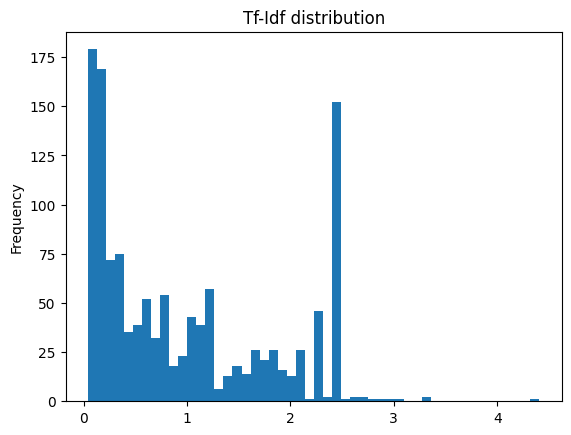

100%|█████████████████████████████████████████████████████████████████████████████████| 284/284 [02:07<00:00,  2.23it/s]


New links of clusters:
Nr of links that are equal to one of max values:  84
[(3.8572147689331513, 181, 182), (3.8572147689331513, 180, 181), (3.958202742966936, 247, 64), (3.8572147689331513, 180, 182), (3.8572147689331513, 229, 130), (3.958202742966936, 64, 247), (3.8572147689331513, 182, 181), (3.8572147689331513, 181, 180), (3.8572147689331513, 182, 180), (3.8572147689331513, 160, 120)]
[(3.8572147689331513, 181, 182), (3.8572147689331513, 180, 181), (3.958202742966936, 247, 64), (3.8572147689331513, 180, 182), (3.8572147689331513, 229, 130), (3.958202742966936, 64, 247), (3.8572147689331513, 182, 181), (3.8572147689331513, 181, 180), (3.8572147689331513, 182, 180), (3.8572147689331513, 160, 120)]
302 67
67 302
271 138
198 197
198 196
Homogeneity: 0.927
Completeness: 0.740
V-measure: 0.823
Rand index: 0.984
ARI: 0.504
MI: 3.650
NMI: 0.823
AMI: 0.686
Cluster accuracy: 0.568
Iteration 21 done.  280 clusters left.

Next Iteration:  22


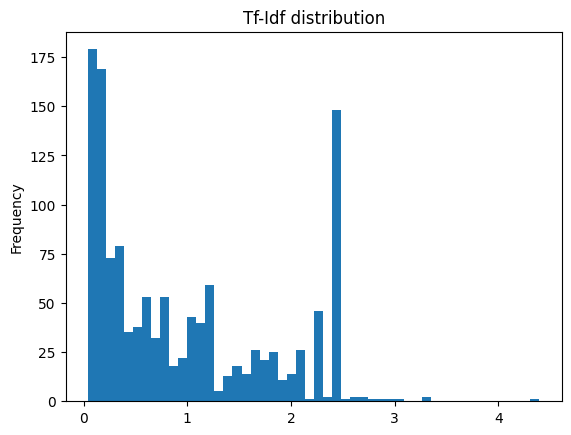

100%|█████████████████████████████████████████████████████████████████████████████████| 280/280 [02:03<00:00,  2.26it/s]


New links of clusters:
Nr of links that are equal to one of max values:  100
[(3.8430301339411947, 120, 159), (3.6888794541139363, 262, 186), (3.8236457178444234, 61, 212), (3.6888794541139363, 254, 48), (3.729999835884101, 261, 26), (3.6888794541139363, 254, 126), (3.729999835884101, 26, 261), (3.8236457178444234, 212, 61), (3.6888794541139363, 254, 139), (3.8430301339411947, 159, 120)]
[(3.8430301339411947, 120, 159), (3.6888794541139363, 262, 186), (3.8236457178444234, 61, 212), (3.6888794541139363, 254, 48), (3.729999835884101, 261, 26), (3.6888794541139363, 254, 126), (3.729999835884101, 26, 261), (3.8236457178444234, 212, 61), (3.6888794541139363, 254, 139), (3.8430301339411947, 159, 120)]
169 127
127 169
248 63
63 248
326 27
Homogeneity: 0.926
Completeness: 0.741
V-measure: 0.823
Rand index: 0.984
ARI: 0.506
MI: 3.648
NMI: 0.823
AMI: 0.687
Cluster accuracy: 0.568
Iteration 22 done.  277 clusters left.

Next Iteration:  23


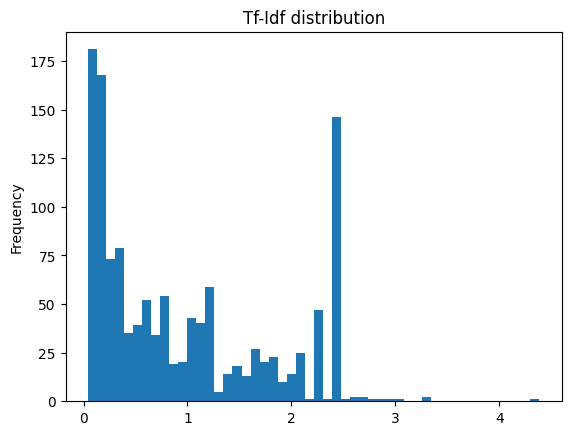

100%|█████████████████████████████████████████████████████████████████████████████████| 277/277 [02:00<00:00,  2.31it/s]


New links of clusters:
Nr of links that are equal to one of max values:  160
[(3.678107357132025, 209, 227), (3.678107357132025, 209, 208), (3.678107357132025, 251, 125), (3.678107357132025, 227, 209), (3.678107357132025, 227, 208), (3.678107357132025, 208, 227), (3.678107357132025, 208, 209), (3.678107357132025, 251, 138), (3.678107357132025, 251, 47), (3.678107357132025, 259, 184)]
[(3.678107357132025, 209, 227), (3.678107357132025, 209, 208), (3.678107357132025, 251, 125), (3.678107357132025, 227, 209), (3.678107357132025, 227, 208), (3.678107357132025, 208, 227), (3.678107357132025, 208, 209), (3.678107357132025, 251, 138), (3.678107357132025, 251, 47), (3.678107357132025, 259, 184)]
327 208
318 148
318 134
318 50
281 247
Homogeneity: 0.925
Completeness: 0.742
V-measure: 0.823
Rand index: 0.984
ARI: 0.506
MI: 3.645
NMI: 0.823
AMI: 0.688
Cluster accuracy: 0.568
Iteration 23 done.  272 clusters left.

Next Iteration:  24


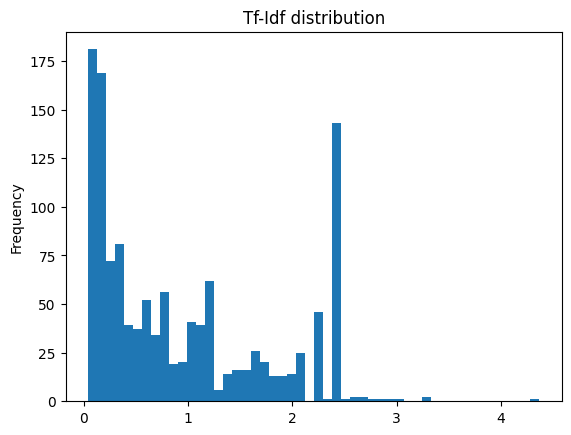

100%|█████████████████████████████████████████████████████████████████████████████████| 272/272 [01:56<00:00,  2.34it/s]


New links of clusters:
Nr of links that are equal to one of max values:  20
[(3.641044652592663, 256, 120), (3.625348299396345, 168, 21), (3.625348299396345, 21, 168), (3.8140425970679424, 222, 204), (3.5681919072887442, 131, 243), (3.8140425970679424, 204, 222), (3.574551125199006, 143, 245), (3.641044652592663, 120, 256), (3.5681919072887442, 243, 131), (3.574551125199006, 245, 143)]
[(3.641044652592663, 256, 120), (3.625348299396345, 168, 21), (3.625348299396345, 21, 168), (3.8140425970679424, 222, 204), (3.5681919072887442, 131, 243), (3.8140425970679424, 204, 222), (3.574551125199006, 143, 245), (3.641044652592663, 120, 256), (3.5681919072887442, 243, 131), (3.574551125199006, 245, 143)]
281 246
246 281
329 130
130 329
188 22
Homogeneity: 0.925
Completeness: 0.743
V-measure: 0.824
Rand index: 0.984
ARI: 0.509
MI: 3.645
NMI: 0.824
AMI: 0.690
Cluster accuracy: 0.570
Iteration 24 done.  269 clusters left.

Next Iteration:  25


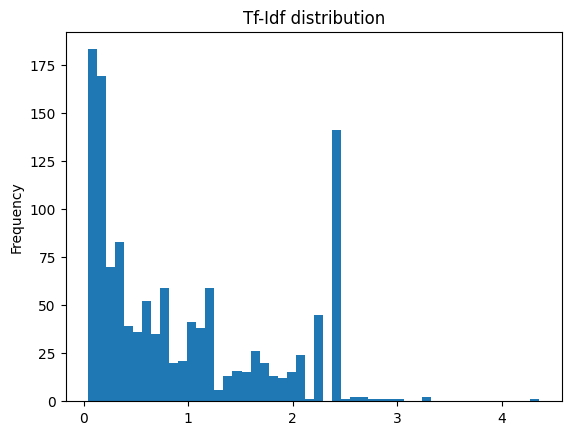

100%|█████████████████████████████████████████████████████████████████████████████████| 269/269 [01:54<00:00,  2.34it/s]


New links of clusters:
Nr of links that are equal to one of max values:  80
[(3.5594117803225354, 241, 130), (3.5594117803225354, 130, 241), (3.564569507174263, 243, 142), (3.5152698379220033, 257, 183), (3.5152698379220033, 257, 47), (3.564569507174263, 142, 243), (3.5152698379220033, 257, 129), (3.5152698379220033, 183, 257), (3.5152698379220033, 183, 129), (3.5152698379220033, 183, 47)]
[(3.5594117803225354, 241, 130), (3.5594117803225354, 130, 241), (3.564569507174263, 243, 142), (3.5152698379220033, 257, 183), (3.5152698379220033, 257, 47), (3.564569507174263, 142, 243), (3.5152698379220033, 257, 129), (3.5152698379220033, 183, 257), (3.5152698379220033, 183, 129), (3.5152698379220033, 183, 47)]
317 156
156 317
312 143
143 312
333 212
Homogeneity: 0.925
Completeness: 0.744
V-measure: 0.825
Rand index: 0.984
ARI: 0.509
MI: 3.645
NMI: 0.825
AMI: 0.691
Cluster accuracy: 0.572
Iteration 25 done.  266 clusters left.

Next Iteration:  26


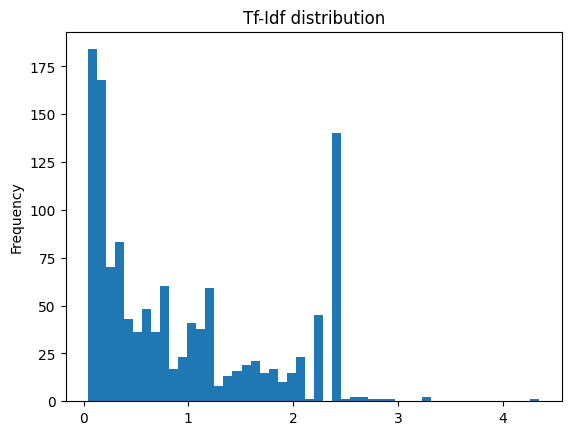

100%|█████████████████████████████████████████████████████████████████████████████████| 266/266 [01:50<00:00,  2.40it/s]


New links of clusters:
Nr of links that are equal to one of max values:  44
[(3.6375861597263857, 47, 254), (3.6375861597263857, 129, 254), (3.477301096804149, 42, 14), (3.6375861597263857, 254, 47), (3.6375861597263857, 47, 129), (3.497668289718173, 23, 6), (3.477301096804149, 14, 42), (3.497668289718173, 6, 23), (3.6375861597263857, 129, 47), (3.6375861597263857, 254, 129)]
[(3.6375861597263857, 47, 254), (3.6375861597263857, 129, 254), (3.477301096804149, 42, 14), (3.6375861597263857, 254, 47), (3.6375861597263857, 47, 129), (3.497668289718173, 23, 6), (3.477301096804149, 14, 42), (3.497668289718173, 6, 23), (3.6375861597263857, 129, 47), (3.6375861597263857, 254, 129)]
333 142
333 52
142 333
142 52
52 333
Homogeneity: 0.925
Completeness: 0.744
V-measure: 0.825
Rand index: 0.984
ARI: 0.509
MI: 3.643
NMI: 0.825
AMI: 0.692
Cluster accuracy: 0.572
Iteration 26 done.  264 clusters left.

Next Iteration:  27


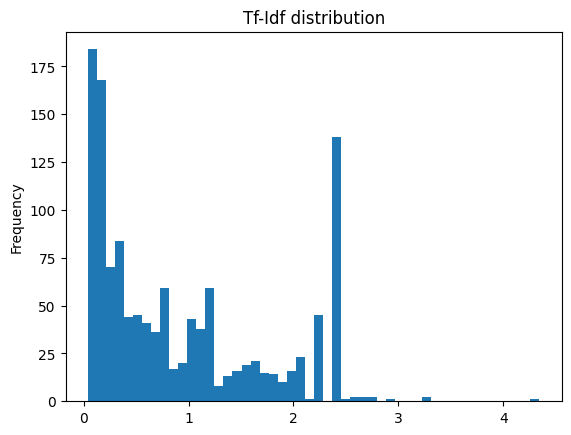

100%|█████████████████████████████████████████████████████████████████████████████████| 264/264 [01:51<00:00,  2.38it/s]


New links of clusters:
Nr of links that are equal to one of max values:  36
[(3.470697291873189, 42, 14), (3.378724525810097, 242, 108), (3.491378951688687, 6, 23), (3.491378951688687, 23, 6), (3.470697291873189, 14, 42), (3.391625267354725, 5, 23), (3.378724525810097, 183, 108), (3.391625267354725, 23, 5), (3.378724525810097, 183, 242), (3.378724525810097, 242, 183)]
Overlapping trips in two clusters: 6 25 Trips:  209 185
Overlapping trips in two clusters: 25 6 Trips:  185 209
[(3.470697291873189, 42, 14), (3.378724525810097, 242, 108), (3.491378951688687, 6, 23), (3.491378951688687, 23, 6), (3.470697291873189, 14, 42), (1.6958126336773625, 5, 23), (3.378724525810097, 183, 108), (1.6958126336773625, 23, 5), (3.378724525810097, 183, 242), (3.378724525810097, 242, 183)]
25 7
7 25
46 15
15 46
320 216
Homogeneity: 0.925
Completeness: 0.745
V-measure: 0.825
Rand index: 0.984
ARI: 0.510
MI: 3.643
NMI: 0.825
AMI: 0.693
Cluster accuracy: 0.573
Iteration 27 done.  261 clusters left.

Next Iter

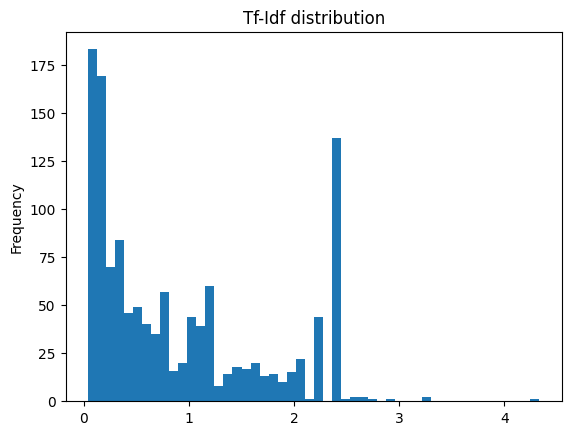

100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [01:48<00:00,  2.41it/s]


New links of clusters:
Nr of links that are equal to one of max values:  68
[(3.4850788656428575, 239, 106), (3.3494310889909378, 173, 147), (3.3494310889909378, 1, 23), (3.3494310889909378, 147, 173), (3.3494310889909378, 124, 241), (3.3494310889909378, 205, 148), (3.4850788656428575, 106, 239), (3.3494310889909378, 148, 205), (3.3494310889909378, 23, 1), (3.3494310889909378, 241, 124)]
[(3.4850788656428575, 239, 106), (3.3494310889909378, 173, 147), (3.3494310889909378, 1, 23), (3.3494310889909378, 147, 173), (3.3494310889909378, 124, 241), (3.3494310889909378, 205, 148), (3.4850788656428575, 106, 239), (3.3494310889909378, 148, 205), (3.3494310889909378, 23, 1), (3.3494310889909378, 241, 124)]
320 118
118 320
323 140
257 166
202 165
Homogeneity: 0.924
Completeness: 0.745
V-measure: 0.825
Rand index: 0.984
ARI: 0.510
MI: 3.640
NMI: 0.825
AMI: 0.693
Cluster accuracy: 0.573
Iteration 28 done.  257 clusters left.

Next Iteration:  29


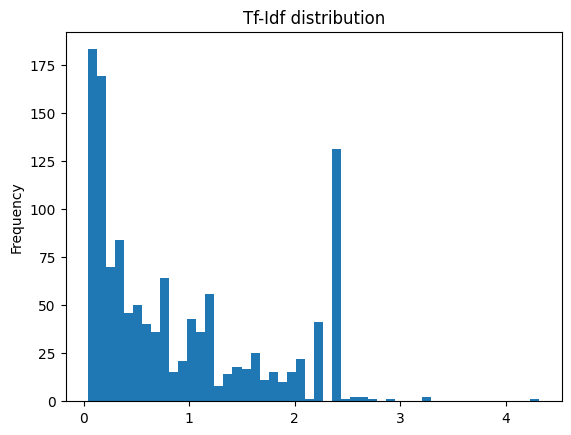

100%|█████████████████████████████████████████████████████████████████████████████████| 257/257 [01:44<00:00,  2.46it/s]


New links of clusters:
Nr of links that are equal to one of max values:  24
[(3.2848661353104855, 134, 159), (3.299171249730087, 181, 179), (3.227836150856583, 151, 102), (3.227836150856583, 149, 102), (3.299171249730087, 179, 181), (3.3378478471703326, 23, 1), (3.2707570686806156, 30, 5), (3.2707570686806156, 5, 30), (3.3378478471703326, 1, 23), (3.2848661353104855, 159, 134)]
[(3.2848661353104855, 134, 159), (3.299171249730087, 181, 179), (3.227836150856583, 151, 102), (3.227836150856583, 149, 102), (3.299171249730087, 179, 181), (3.3378478471703326, 23, 1), (3.2707570686806156, 30, 5), (3.2707570686806156, 5, 30), (3.3378478471703326, 1, 23), (3.2848661353104855, 159, 134)]
26 2
2 26
220 218
218 220
184 152
Homogeneity: 0.924
Completeness: 0.746
V-measure: 0.825
Rand index: 0.984
ARI: 0.511
MI: 3.638
NMI: 0.825
AMI: 0.694
Cluster accuracy: 0.576
Iteration 29 done.  254 clusters left.

Next Iteration:  30


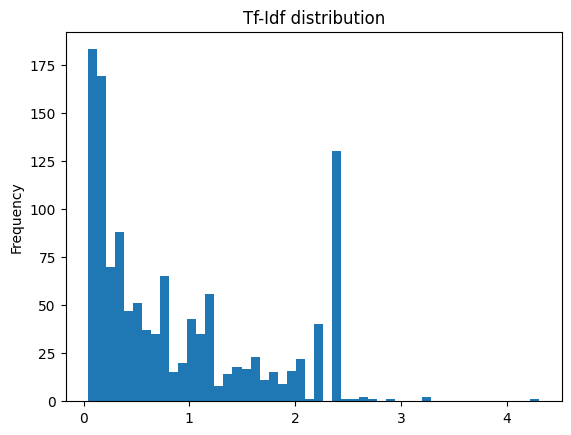

 70%|█████████████████████████████████████████████████████████                        | 179/254 [01:11<00:27,  2.77it/s]

In [ ]:
iteration = 1

# Define stopping criteria (either k is reached or min_sim is triggered)
K_target = 72
Min_sim = 1.0

while True:
    print('\nNext Iteration: ', iteration)
    # Get new points gdf matched with tessellation that contains updated clustering column
    points = get_points(gdf, tessellation)
    
    # Compute location entropy for latest clustering (inverse normalized entropy)
#     points['location_entropy'] = points.tile_ID.progress_apply(lambda x: get_location_entropy(x, points))
#     points['location_entropy'] = points.location_entropy.apply(lambda x: 1 - (x - points.location_entropy.min())/(points.location_entropy.max() - points.location_entropy.min()))
#     points.location_entropy.plot.hist(bins=30, title="Inverse location_entropy distribution")
#     plt.show()
    
    # Update location frequencies and loc frequency-inverse cluster frequency
    loc_frequencies = points.groupby(['clustering_HL', 'tile_ID'])[['TRIP_ID']].nunique().reset_index().sort_values('clustering_HL').rename(columns={'TRIP_ID': 'freq'})
    loc_frequencies['tf_idf'] = loc_frequencies.apply(lambda x: get_inverse_loc_frequency(x, loc_frequencies, points), axis=1)
    loc_frequencies.tf_idf.plot.hist(bins=50, title="Tf-Idf distribution")
    plt.show()
    
    # Recalculate similarities between latest clusters
    M = np.zeros((loc_frequencies.clustering_HL.nunique(), loc_frequencies.clustering_HL.nunique()))
    for i, cl_i in tqdm(enumerate(loc_frequencies.clustering_HL.unique()), total=loc_frequencies.clustering_HL.nunique()):
        for j, cl_j in enumerate(loc_frequencies.clustering_HL.unique()):
            if i == j:
                continue
            M[i, j] = get_location_similarity(cl_i, cl_j, loc_frequencies, points)
    np.fill_diagonal(M, 0)
    
    # Select n best links and assign new clustering IDs
    print('New links of clusters:')
    max_n =  get_max_n(M)
    # Adjust scores based on overlapping trips in the two candidate clusters
    print(max_n)
    max_n = [(t[0] * 1/(find_nr_overlaps(loc_frequencies.clustering_HL.unique()[t[1]], loc_frequencies.clustering_HL.unique()[t[2]], gdf) + 1), t[1], t[2]) for t in max_n]
    print(max_n)
    
    # Take the 5 best fitting clusters
    for i, tup in enumerate(sorted(max_n, reverse=True)[:5]):
        cl_1 = loc_frequencies.clustering_HL.unique()[tup[1]]
        cl_2 = loc_frequencies.clustering_HL.unique()[tup[2]]
        print(cl_1, cl_2)
        # Assign new clustering ids (merge clustering ids)
        gdf['clustering_HL'] = gdf.clustering_HL.apply(lambda x: cl_1 if x == cl_2 else x)
    
    # Evaluate result of iteration
    attack.evaluate(gdf.clustering_HL.tolist(), gdf)
    store_results_recursive_search(gdf.clustering_HL.tolist(), gdf)
    
    print('Iteration', iteration, 'done. ', gdf.clustering_HL.nunique(), 'clusters left.')
    
    # Check break conditions
    if gdf.clustering_HL.nunique() <= K_target:
        print("K clusters reached! Done!")
        break
    if sorted(max_n, reverse=True)[0][0] < Min_sim:
        print("No good matches to make left! Done!")
        break
        
    iteration += 1

In [ ]:
gdf.drop(['START_POINT', 'END_POINT'], axis=1).to_file("data/freemove/freemove_clustering_tfidf.geojson", driver="GeoJSON")